In [46]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 32, 20

# Read in data and do basic massaging

In [47]:
df_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_raw.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20
0,NaN,Thailand,15.0,101.0,2,3,5,7,8,8,...,48,50,50,50,53,59,70,75,82,114
1,NaN,Japan,36.0,138.0,2,1,2,2,4,4,...,420,461,502,511,581,639,639,701,773,839


In [48]:
df = df_raw.drop(['Lat', 'Long'], axis=1)                   # drop the Lat/Lon columns
df = df.set_index(['Country/Region', 'Province/State'])     # set index (for rows) to country + state
df = df.stack().unstack(level=[0,1])                        # rotate so country+state is across top and dates go down
df.head(2)

Country/Region Thailand Japan Singapore Nepal Malaysia           Canada  \
Province/State      NaN   NaN       NaN   NaN      NaN British Columbia   
1/22/20               2     2         0     0        0                0   
1/23/20               3     1         1     0        0                0   

Country/Region       Australia                     Cambodia  ...  \
Province/State New South Wales Victoria Queensland      NaN  ...   
1/22/20                      0        0          0        0  ...   
1/23/20                      0        0          0        0  ...   

Country/Region        France   US Kosovo                    Canada  \
Province/State French Guiana Guam    NaN Newfoundland and Labrador   
1/22/20                    0    0      0                         0   
1/23/20                    0    0      0                         0   

Country/Region                      Central African Republic  \
Province/State Prince Edward Island                      NaN   
1/22/20                           0                        0   
1/23/20                           0                        0   

Country/Region Congo (Brazzaville) Equatorial Guinea  France Uzbekistan  
Province/State                 NaN               NaN Mayotte        NaN  
1/22/20                          0                 0       0          0  
1/23/20                          0                 0       0          0  

[2 rows x 450 columns]

# Fix the State datasets for CA and NY
Notice that the dataset for US stops reporting at county level on 3/10 and moves to state level. We need to create a merged California dataset with summation of counties before 3/10 and the 'Califorina' column from 3/10 onward

In [49]:
# Notice that the dataset for US stops reporting at county level on 3/10 and moves to state level
idx =  pd.IndexSlice
df.loc['3/7/20':'3/12/20',idx[:,['California', 'Santa Clara County, CA', 'New York', 'Suffolk County, NY']]]

Country/Region       US                                                     
Province/State New York California Suffolk County, NY Santa Clara County, CA
3/7/20                0          0                  0                     32
3/8/20                0          0                  1                     38
3/9/20                0          0                  1                     38
3/10/20             173        144                  0                      0
3/11/20             220        177                  0                      0
3/12/20             328        221                  0                      0

In [50]:
# Create a merged California dataset with summation of counties before 3/10 and the
# 'Califorina' column from 3/10 onward
cal_locations = df.columns.levels[1][df.columns.levels[1].str.contains(", CA")] # get all index entries (counties) ending in ", CA"
cal_locations = list(cal_locations.values)
cal_locations.append('California')                                              # include the 'California' state column to the list
cal_merged = df.loc[:, idx[:, cal_locations]].sum(axis=1)                       # cal_merged is the new California dataset

ny_locations = df.columns.levels[1][df.columns.levels[1].str.contains(", NY")] # get all index entries (counties) ending in ", NY"
ny_locations = list(ny_locations.values)
ny_locations.append('New York')                                              # include the 'New York' state column to the list
ny_merged = df.loc[:, idx[:, ny_locations]].sum(axis=1)                      

cal_merged['3/7/20':'3/12/20']

3/7/20      81
3/8/20      95
3/9/20     101
3/10/20    144
3/11/20    177
3/12/20    221
dtype: int64

# Narrow down to a set of interesting countries plus California and graph

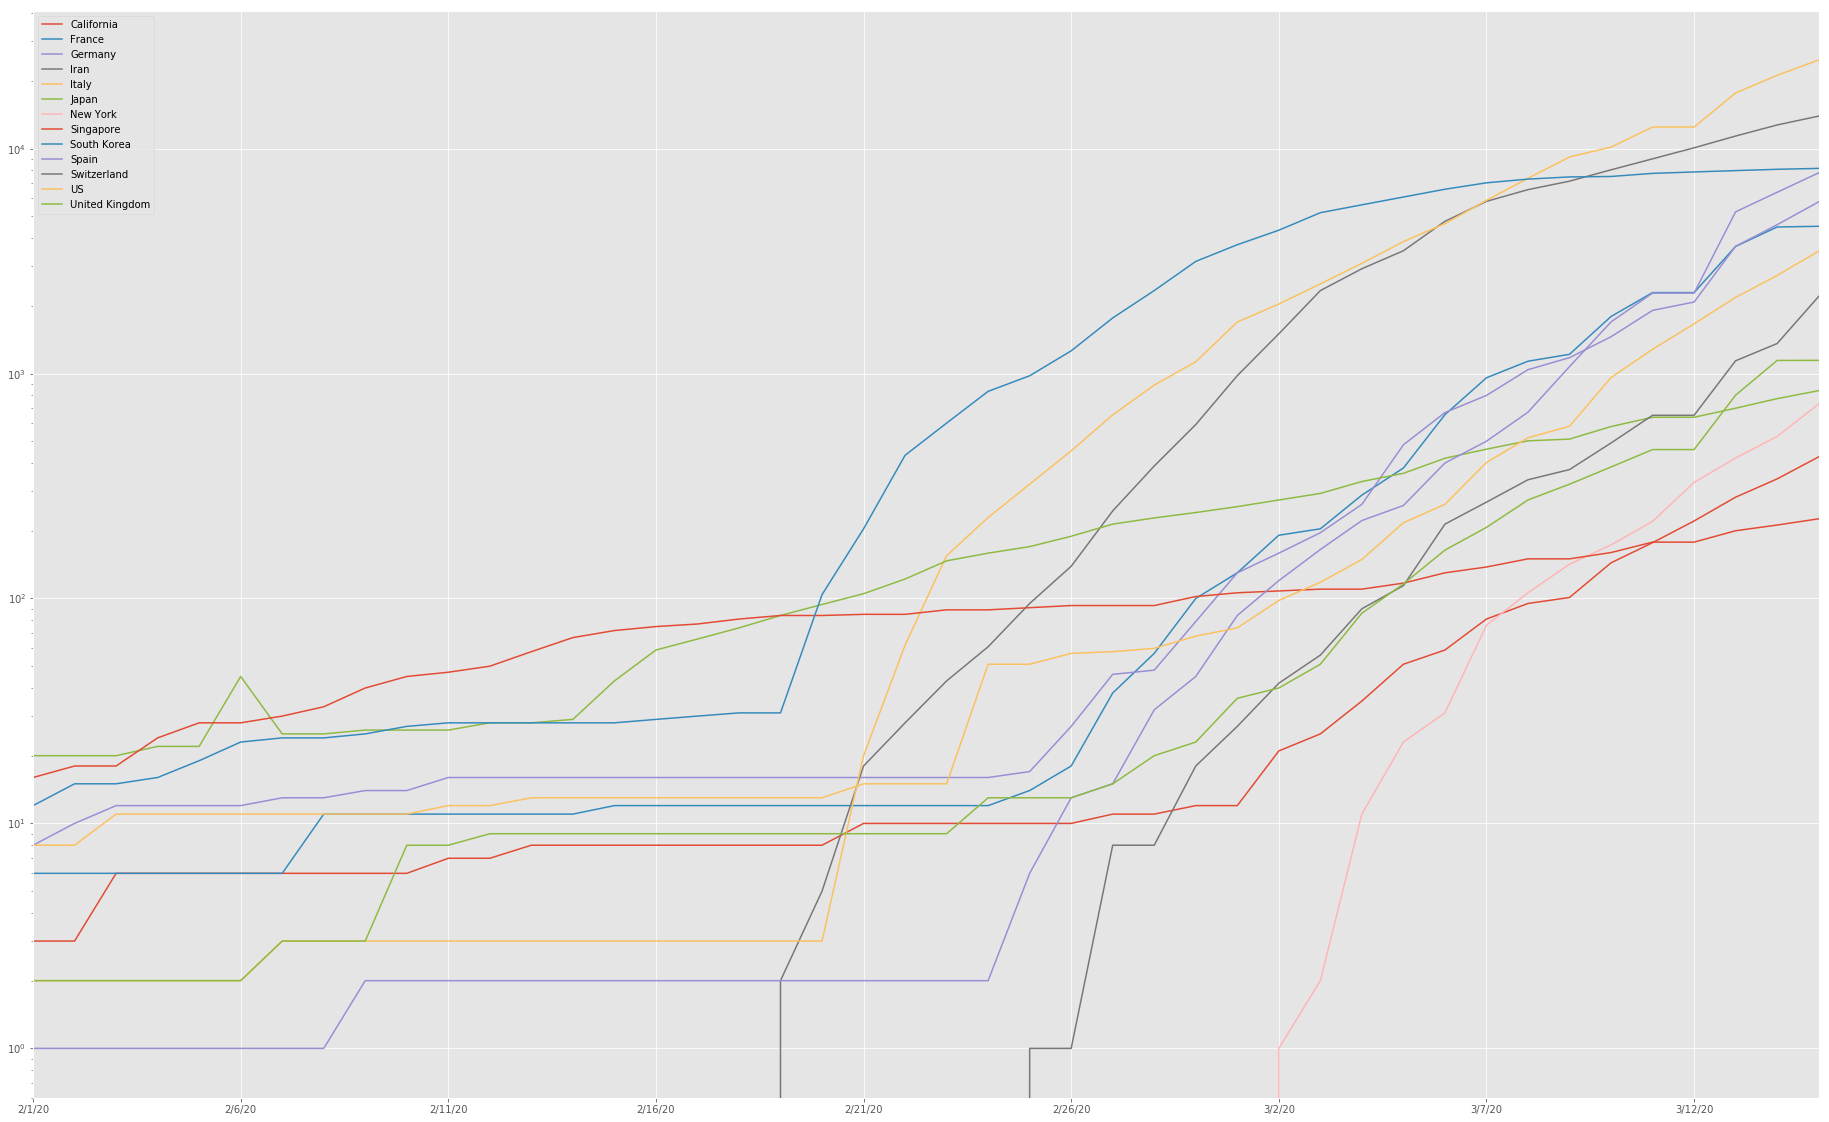

In [51]:
newdf = pd.DataFrame(index = df.index,
                     data = {
                         'Japan': df.loc[:, idx['Japan',:]].sum(axis=1),
                         'US': df.loc[:, idx['US',:]].sum(axis=1),
                         'Singapore': df.loc[:, idx['Singapore',:]].sum(axis=1),
                         'Italy': df.loc[:, idx['Italy',:]].sum(axis=1),
                         'Iran': df.loc[:, idx['Iran',:]].sum(axis=1),
                         'France': df.loc[:, idx['France',:]].sum(axis=1),
                         'Spain': df.loc[:, idx['Spain',:]].sum(axis=1),
                         'Germany': df.loc[:, idx['Germany',:]].sum(axis=1),
                         'Switzerland': df.loc[:, idx['Switzerland',:]].sum(axis=1),
                         'United Kingdom': df.loc[:, idx['United Kingdom',:]].sum(axis=1),
                         'South Korea': df.loc[:, idx['Korea, South',:]].sum(axis=1),
                         'California': cal_merged,
                         'New York': ny_merged,
                     }

)
newdf.loc['2/1/20':,:].plot(logy=True)

# Create a 'days since 100 cases' graph

In [52]:
newdf.head(2)

,California,France,Germany,Iran,Italy,Japan,New York,Singapore,South Korea,Spain,Switzerland,US,United Kingdom
1/22/20,0,0,0,0,0,2,0,0,1,0,0,1,0
1/23/20,0,0,0,0,0,1,0,1,1,0,0,1,0


Text(0, 0.5, 'Number of confirmed cases')

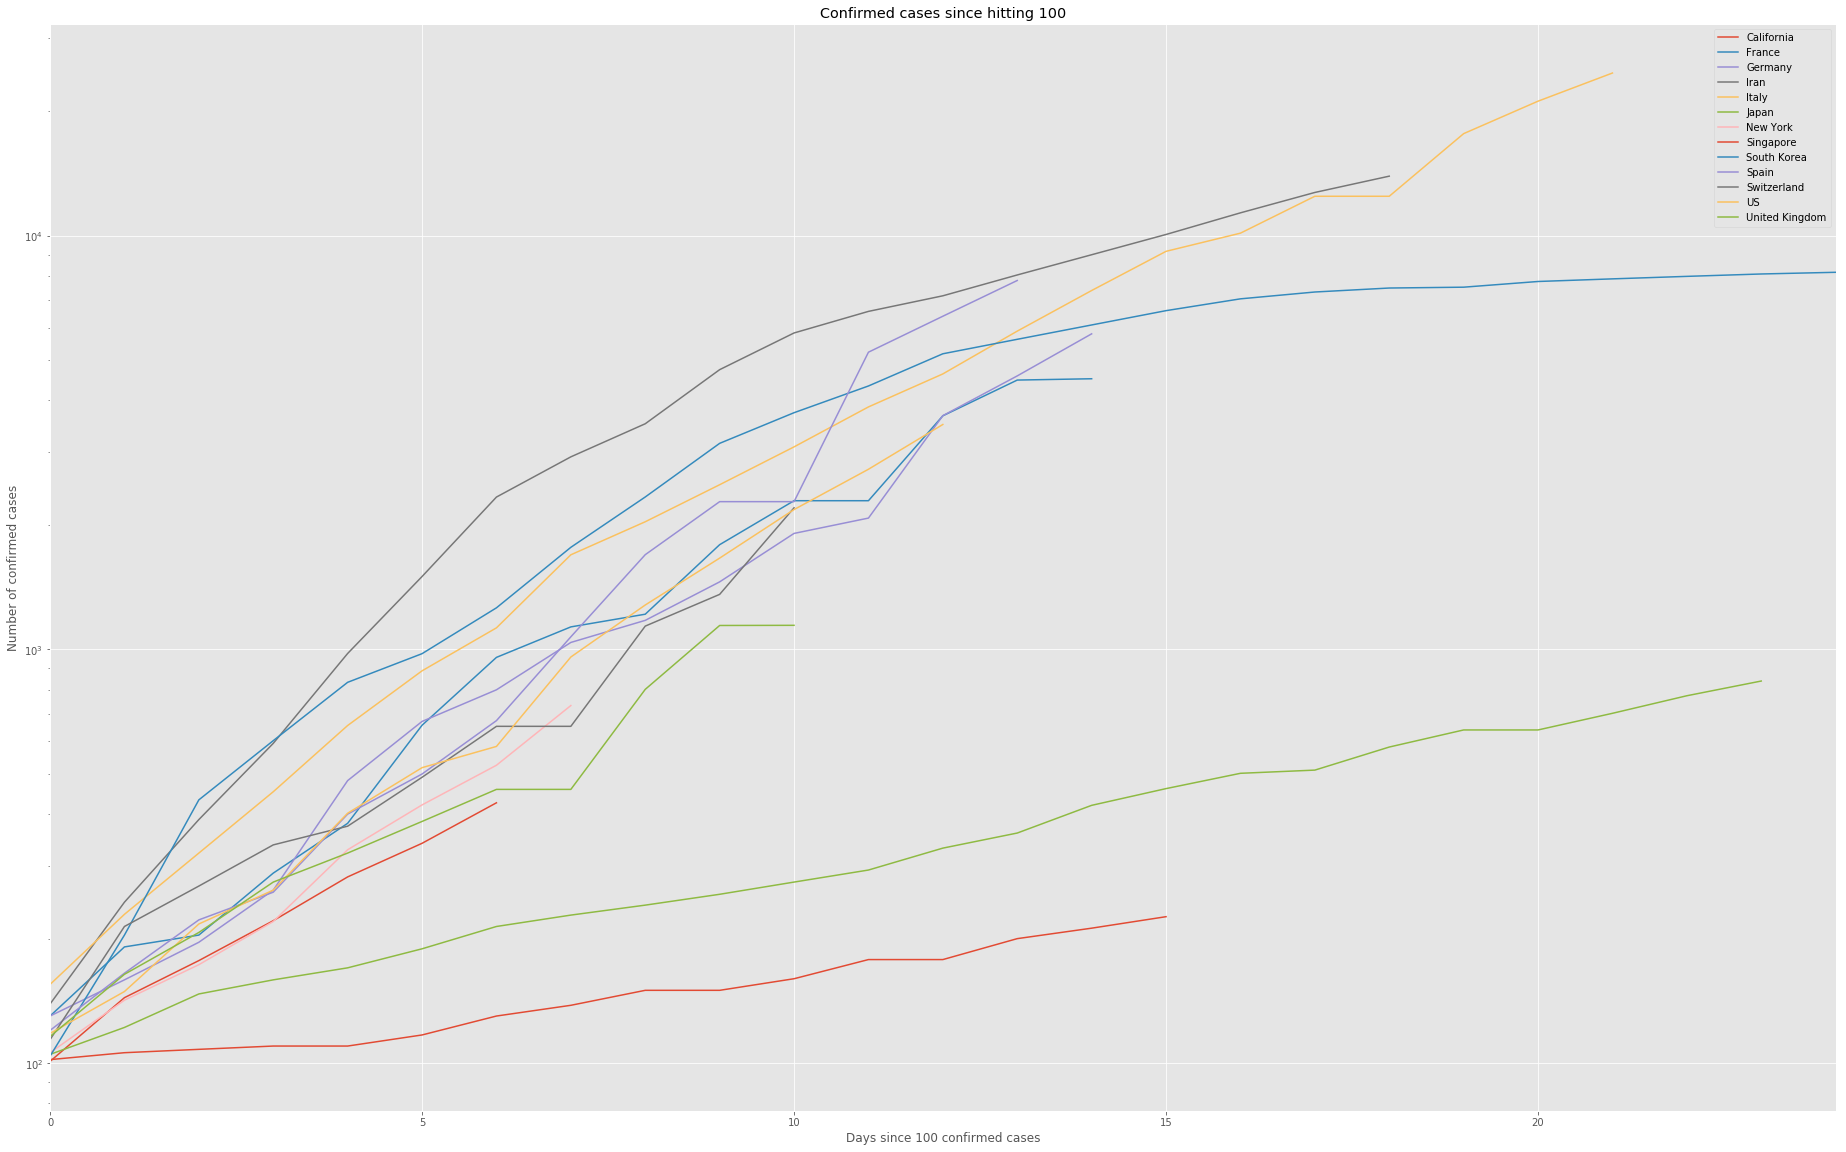

In [53]:
daysSince100 = pd.DataFrame(index=range(0,len(newdf.index)))
for location in newdf.columns:
    # create list of data once above 100
    tempList = [newdf.loc[date, location] 
                              for date in newdf[location].index 
                              if newdf.loc[date, location] > 100]
    # put that list in another list that has NaN's buffered out to length of the DataFrame
    tempListFilled = list()
    for index, _ in enumerate(daysSince100.index):
        if index < len(tempList):
            tempListFilled.append(tempList[index])
        else:
            tempListFilled.append(np.NaN)
    # add the buffered list to the dataframe as a new column
    daysSince100[location] = tempListFilled
daysSince100 = daysSince100.dropna(axis=0, how='all')
ax = daysSince100.plot(title='Confirmed cases since hitting 100', logy=True)
ax.set_xlabel('Days since 100 confirmed cases')
ax.set_ylabel('Number of confirmed cases')

In [54]:
daysSince100

,California,France,Germany,Iran,Italy,Japan,New York,Singapore,South Korea,Spain,Switzerland,US,United Kingdom
0,101.0,130.0,130.0,139.0,155.0,105.0,106.0,102.0,104.0,120.0,114.0,118.0,116.0
1,144.0,191.0,159.0,245.0,229.0,122.0,142.0,106.0,204.0,165.0,214.0,149.0,164.0
2,177.0,204.0,196.0,388.0,322.0,147.0,173.0,108.0,433.0,222.0,268.0,217.0,207.0
3,221.0,288.0,262.0,593.0,453.0,159.0,220.0,110.0,602.0,259.0,337.0,262.0,274.0
4,282.0,380.0,482.0,978.0,655.0,170.0,328.0,110.0,833.0,400.0,374.0,402.0,322.0
5,340.0,656.0,670.0,1501.0,888.0,189.0,421.0,117.0,977.0,500.0,491.0,518.0,384.0
6,426.0,957.0,799.0,2336.0,1128.0,214.0,525.0,130.0,1261.0,673.0,652.0,583.0,459.0
7,NaN,1134.0,1040.0,2922.0,1694.0,228.0,732.0,138.0,1766.0,1073.0,652.0,959.0,459.0
8,NaN,1217.0,1176.0,3513.0,2036.0,241.0,NaN,150.0,2337.0,1695.0,1139.0,1281.0,801.0
9,NaN,1792.0,1457.0,4747.0,2502.0,256.0,NaN,150.0,3150.0,2277.0,1359.0,1663.0,1143.0
